In [2]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
from graphmodels.validation import score_model, plot_diagnostic, plot_baseline_vs_computation
import pandas as pd
import plotly.express as px
from sklearn.metrics import r2_score
from database import select_dataset
from models.Hermen.model_GE3 import GE3_models

from graphmodels.utils import df_to_data_dict, get_X_y_from_data

# Newer

In [10]:
pop = select_dataset('population')
#emissions = select_dataset('emissions')

In [11]:
emissions = pd.read_csv('models/Hermen/data/GY_GE_GU_GM_GP_GT.csv')

/home/simon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
model_df = pd.concat([emissions, pop])
model_df = model_df[~model_df.Item.isin(['All Animals'])]

In [15]:
from graphmodels.utils import df_to_data_dict

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]#.fillna(0)
    return X


def fill_missing_values(df):
    return df
#     return df.groupby(level='ISO').fillna(method='ffill')\
#              .groupby(level='ISO').fillna(method='bfill')


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    item_df = df[df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')

    data_dict.update(df_to_dict(non_item_df))
    data_dict.update(df_to_dict(item_df))

    return data_dict


In [16]:
itemized = ['TAi', 'EF_EEi', 'EECH4', 'TEE_CO2eq',
       'M_ASi', 'EF_ASi', 'E_ASi', 'TMA_CO2eq', 'M_Ti', 'EF_CH4Ti',
       'EF_Ti', 'E_TCH4i', 'E_Ti', 'TMT_CO2eq', 'M_LPi', 'EF_Li', 'E_Li',
       'TMP_CO2eq', 'TMi', 'MM_ASi', 'MM_LPi', 'MM_Ti', 'MYi',]

data_dict = df_to_data_dict(model_df, itemized)

In [17]:
res = []
for model_name, model in GE3_models.items():
    print(model_name)
    X, y = get_X_y_from_data(model, data_dict)
    print(score_model(model, X, y))
    print()

TMi_model
TMi
    r2  correlation          rmse Variable
0  1.0          1.0  1.016920e-15      TMi

M_xi_model
M_Ti
M_LPi
M_ASi
    r2  correlation          rmse Variable
0  1.0          1.0  3.249331e-16     M_Ti
1  1.0          1.0  3.635216e-16    M_LPi
2  1.0          1.0  2.520746e-16    M_ASi

TMP_CO2eq_model
TMP_CO2eq
         r2  correlation       rmse   Variable
0  0.999997     0.999999  17.092812  TMP_CO2eq

TMT_CO2eq_model
E_Ti
E_TCH4i
TMT_CO2eq
         r2  correlation          rmse   Variable
0  0.999992     0.999997  2.619308e-05       E_Ti
1  1.000000     1.000000  1.297824e-08    E_TCH4i
2  0.999997     0.999999  2.517425e+00  TMT_CO2eq

TMA_CO2eq_model
TMA_CO2eq
         r2  correlation      rmse   Variable
0  0.999993          1.0  1.136032  TMA_CO2eq

TEE_CO2eq_model
TEE_CO2eq
    r2  correlation          rmse   Variable
0  1.0          1.0  4.353519e-10  TEE_CO2eq

FE_CO2eq_model
FE_CO2eq
         r2  correlation         rmse  Variable
0  0.999987     0.999994  238

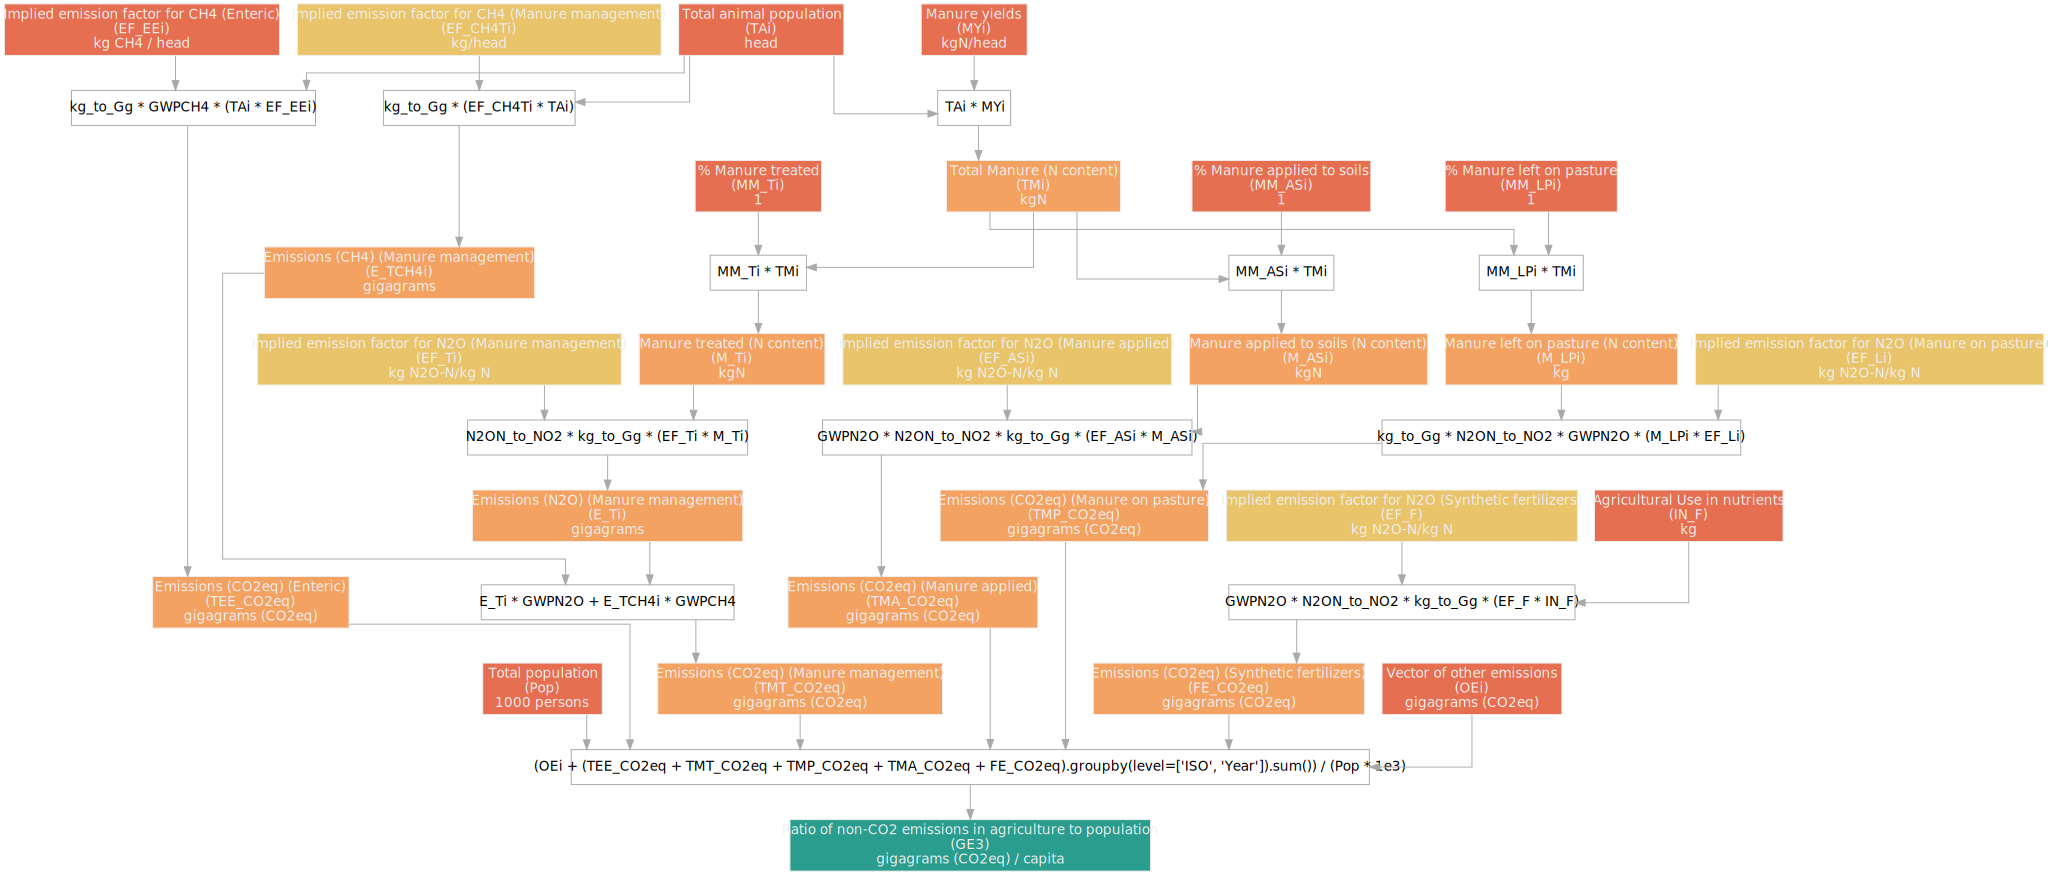

In [18]:
GE3_models['GE3_model'].draw()

In [ ]:
X, y = get_X_y_from_data(GE3_models['GE3_model'], data_dict)
res = GE3_models['GE3_model'].run(X)

In [34]:
res['MM_LPi'].loc['FRA', 2014].dropna() #+ res['MM_ASi'].loc['FRA', 2014].dropna() + res['MM_Ti'].loc['FRA', 2014].dropna()

Item
Asses                 0.923077
Cattle                0.184789
Cattle, dairy         0.131656
Cattle, non-dairy     0.211105
Chickens              0.010114
Chickens, broilers    0.010114
Chickens, layers      0.010114
Ducks                 0.010114
Goats                 0.923077
Horses                0.923077
Mules                 0.923077
Mules and Asses       0.923077
Poultry Birds         0.010114
Sheep                 0.770935
Sheep and Goats       0.795982
Swine                 0.000000
Swine, breeding       0.000000
Swine, market         0.000000
Turkeys               0.010114
Name: MM_LPi, dtype: float64

In [36]:
res['MM_Ti'].loc['FRA', 2014].dropna()

Item
Asses                 0.038462
Cattle                0.474442
Cattle, dairy         0.526626
Cattle, non-dairy     0.448597
Chickens              0.495575
Chickens, broilers    0.495575
Chickens, layers      0.495575
Ducks                 0.495575
Goats                 0.038462
Horses                0.038462
Mules                 0.038462
Mules and Asses       0.038462
Poultry Birds         0.495575
Sheep                 0.115197
Sheep and Goats       0.102564
Swine                 0.589141
Swine, breeding       0.585835
Swine, market         0.590348
Turkeys               0.495575
Name: MM_Ti, dtype: float64

In [37]:
res['MM_ASi'].loc['FRA', 2014].dropna()

Item
Asses                 0.038462
Cattle                0.340769
Cattle, dairy         0.341718
Cattle, non-dairy     0.340298
Chickens              0.494311
Chickens, broilers    0.494311
Chickens, layers      0.494311
Ducks                 0.494311
Goats                 0.038462
Horses                0.038462
Mules                 0.038462
Mules and Asses       0.038462
Poultry Birds         0.494311
Sheep                 0.113868
Sheep and Goats       0.101454
Swine                 0.410859
Swine, breeding       0.414165
Swine, market         0.409652
Turkeys               0.494311
Name: MM_ASi, dtype: float64

In [ ]:
#test = test.append({'Item': 'FE_CO2eq', 'Value': data_dict['FE_CO2eq'].loc['FRA', 2014], 'Variable':'Agricultural non-CO2 emissions'}, ignore_index=True)

#test = test.append({'Item': 'OEi_CO2eq', 'Value': data_dict['OEi'].loc['FRA', 2014], 'Variable':'Agricultural non-CO2 emissions'}, ignore_index=True)

#test = test.append({'Item': 'lalal', 'Value': 10000, 'Variable':'OEi_CO2eq'}, ignore_index=True)

In [38]:
def run_GE3_scenario(data_dict, MM_Ti=1/3, MM_ASi=1/3, MM_LPi=1/3):

    data_dict = data_dict.copy()

    data_dict['MM_Ti'] = MM_Ti
    data_dict['MM_ASi'] = MM_ASi
    data_dict['MM_LPi'] = MM_LPi

    results = GE3_models['GE3_model'].run(data_dict)

    return results

In [80]:
filtered_data_dict = {k: v.loc['FRA', 2018, :] for k, v in data_dict.items()}

In [89]:
result =  run_GE3_scenario(filtered_data_dict, 1/3, 1/3, 1/3)

In [90]:
test = {k: v for k, v in result.items() if k in ['TEE_CO2eq', 'TMA_CO2eq', 'TMT_CO2eq', 'TMP_CO2eq']}
def format_data_dict_sankey(data_dict=test):
    data_dict = data_dict.copy()

    # grab data and format
    data = pd.concat([v.to_frame(name='Value').assign(Variable=k) for k, v in data_dict.items()], axis=0).reset_index().dropna()
    
    data = pd.concat([data, data.groupby('Variable').sum().reset_index().rename(columns={"Variable": 'Item'}).assign(Variable='Non-CO2 agricultural emissions')])

    # add encoding for Sanky
    le = LabelEncoder() 
    encoded = le.fit_transform(data[['Item', 'Variable']].values.flatten()).reshape(-1, 2)

    data[['Source', 'Target']] = encoded

    return data,  le.classes_

def plot_sanky_GE3(data, classes):
    '''To improve, should write a more general wrapper for Sankey'''

    fig = go.Figure(data=[go.Sankey(
        node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = classes,
        #color = "blue"
        ),
        link = dict(
        target = data['Target'],
        source= data['Source'],
        value = data['Value']
    ))])

    fig.update_layout(title_text=f"Agricultural Animal Emissions", font_size=10)
    fig.show()


d, c = format_data_dict_sankey()


plot_sanky_GE3(d, c)